# `lenstronomy` only modeling
### Fit both a Sérsic source and a parametric lens model (SIE + shear)

Using solely the original `lenstronomy`, for comparison with our code.

__last update__: 12/07/21

In [25]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Basic imports
import time
import corner
import numpy as np
from copy import deepcopy
from scipy.optimize import minimize

# lenstronomy
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import image_util
from lenstronomy.Plots import chain_plot

# Universal font size
FS = 18

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [11]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [12]:
source_light_model_list = ['SERSIC']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 20.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15}]

### Lens model (SIE + external shear)

In [13]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR']
lens_mass_model = LensModel(lens_mass_model_list)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0., 'dec_0': 0.}]

### Lens light model

In [14]:
# Lens light
lens_light_model_list = [] #['SERSIC_ELLIPSE']
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}] # [{'amp': 20.0, 'R_sersic': 2., 'n_sersic': 3., 'e1': 0.15, 'e2': -0.04, 'center_x': 0., 'center_y': 0.}]

kwargs_true = {
    'kwargs_lens': kwargs_lens_mass, 
    'kwargs_source': kwargs_source_light, 
    'kwargs_lens_light': kwargs_lens_light
}

### PSF

In [15]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Image model

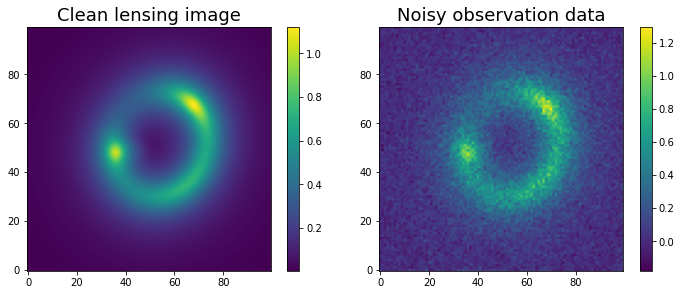

In [16]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
image_model = ImageModel(data_class=pixel_grid,
                         psf_class=psf,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         point_source_class=None,
                         kwargs_numerics=kwargs_numerics)

image = image_model.image(**kwargs_true)

# Noise
exp_time = 100
sigma_bkd = 0.05
poisson = image_util.add_poisson(image, exp_time)
gaussian = image_util.add_background(image, sigma_bkd)

# Observed noisy data
data = image + gaussian + poisson

noise_var = np.abs(image) / exp_time + gaussian.var()

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower')
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower')
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

## Lens mass + source model fitting

In [17]:
kwargs_data = {
    'image_data': data,
    'background_rms': sigma_bkd,
    'exposure_time': exp_time,
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
    'transform_pix2angle': transform_pix2angle,
}

kwargs_data_joint = {
    'multi_band_list': [[kwargs_data, kwargs_psf, kwargs_numerics]],
    'multi_band_type': 'single-band',
}
kwargs_constraints = {
    'solver_type': 'NONE',
}
kwargs_likelihood = {
    'image_position_likelihood': True,
    'image_likelihood_mask_list': None,
    'check_bounds': True,
}

kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_light_model_list': source_light_model_list,
    'lens_light_model_list': lens_light_model_list,
}

kwargs_lens_init = [{'theta_E': 1., 'e1': 1e-3, 'e2': 1e-3, 'center_x': 1e-3, 'center_y': 1e-3}, {'gamma1': 0., 'gamma2': 0.}]
kwargs_lens_sigma = [{'theta_E': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1}, {'gamma1': 0.1, 'gamma2': 0.1}]
kwargs_lens_lower = [{'theta_E': 0.001, 'e1': -0.8, 'e2': -0.8, 'center_x': -5., 'center_y': -5.}, {'gamma1': -0.8, 'gamma2': -0.8}]
kwargs_lens_upper = [{'theta_E': 5., 'e1': 0.8, 'e2': 0.8, 'center_x': 5., 'center_y': 5.}, {'gamma1': 0.8, 'gamma2': 0.8}]
kwargs_lens_fixed = [{}, {'ra_0': 0., 'dec_0': 0.}]

kwargs_source_init = [{'R_sersic': 1.0, 'n_sersic': 1.0, 'center_x': 0.0, 'center_y': 0.0}]
kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.1, 'center_x': 0.1, 'center_y': 0.1}]
kwargs_source_lower = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'center_x': -5., 'center_y': -5.}]
kwargs_source_upper = [{'R_sersic': 10., 'n_sersic': 8., 'center_x': 5., 'center_y': 5.}]
kwargs_source_fixed = [{}]

kwargs_lens_light_init = [{'R_sersic': 1.0, 'n_sersic': 1.0, 'e1': 1e-3, 'e2': 1e-3, 'center_x': 1e-3, 'center_y': 1e-3}]
kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1}]
kwargs_lens_light_lower = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.8, 'e2': -0.8, 'center_x': -5., 'center_y': -5.}]
kwargs_lens_light_upper = [{'R_sersic': 10., 'n_sersic': 8., 'e1': 0.8, 'e2': 0.8, 'center_x': 5., 'center_y': 5.}]
kwargs_lens_light_fixed = [{}]

kwargs_params = {
    'lens_model': [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lens_lower, kwargs_lens_upper],
    'source_model': [kwargs_source_init, kwargs_source_sigma, kwargs_source_fixed, kwargs_source_lower, kwargs_source_upper],
    'lens_light_model': [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_lens_light_fixed, kwargs_lens_light_lower, kwargs_lens_light_upper],
}

fit_sequence = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)


### Run PSO

In [18]:
# Optimise !
start = time.time()
chain_list = fit_sequence.fit_sequence(
    [['PSO', {'n_particles': 100, 'n_iterations': 100, 'threadCount': 1}]]
)
runtime = time.time() - start
print("Runtime:", runtime)

kwargs_final = deepcopy(fit_sequence.best_fit())

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.0135991521341323 reduced X^2 of best position
-5061.914165757857 logL
9988.0 effective number of data points
[{'theta_E': 1.6060278054081676, 'e1': 0.15524470271963806, 'e2': -0.04514183970059699, 'center_x': 1.2820161163778574e-05, 'center_y': -0.0034310224174675962}, {'gamma1': -0.007534327983323733, 'gamma2': 0.027624967273659984, 'ra_0': 0.0, 'dec_0': 0.0}] lens result
[{'amp': 1, 'R_sersic': 1.2658324696149987, 'n_sersic': 1.557203376035699, 'center_x': 0.3999586374134559, 'center_y': 0.1487360480483063}] source result
[] lens light result
[] point source result
{} special param result
101.89521884918213 time used for  PSO
Runtime: 101.91261386871338


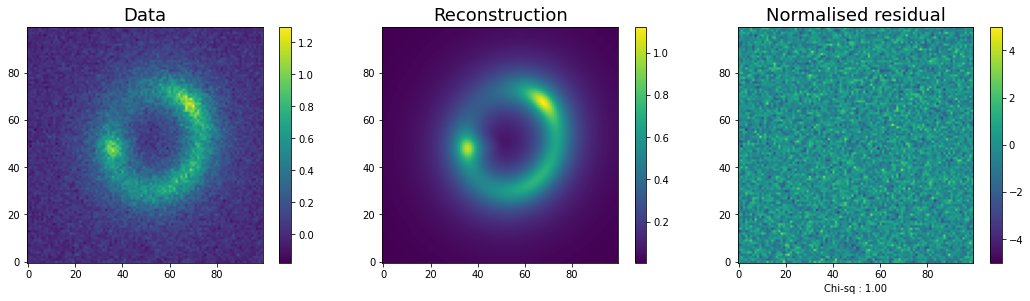

In [32]:
def plot_image_model(kwargs):
    data_class = ImageData(data, ra_at_xy_0=ra_at_xy_0, dec_at_xy_0=dec_at_xy_0,
                           transform_pix2angle=transform_pix2angle,
                           background_rms=sigma_bkd, noise_map=np.sqrt(noise_var))
    image_model_rec = ImageLinearFit(data_class=data_class,
                                     psf_class=psf,
                                     lens_model_class=lens_mass_model,
                                     source_model_class=source_light_model,
                                     lens_light_model_class=lens_light_model,
                                     point_source_class=None,
                                     kwargs_numerics=kwargs_numerics)
    rec, _, _, _ = image_model_rec.image_linear_solve(**kwargs)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ax1, ax2, ax3 = axes
    img1 = ax1.imshow(data, origin='lower')
    ax1.set_title("Data", fontsize=FS)
    img2 = ax2.imshow(rec, origin='lower')
    ax2.set_title("Reconstruction", fontsize=FS)
    img3 = ax3.imshow((data - rec) / np.sqrt(noise_var), origin='lower', vmin=-5, vmax=5)
    ax3.set_title("Normalised residual", fontsize=FS)
    red_chi2 = np.sum((data - rec)**2 / noise_var) / data.size
    ax3.set_xlabel(f"Chi-sq : {red_chi2:.2f}")
    for img, ax in zip((img1, img2, img3), axes):
        fig.colorbar(img, ax=ax)
    fig.tight_layout()
    
plot_image_model(kwargs_final)

In [33]:
def print_errors(kwargs):
    def print_error_sgl(name, value, estimate):
        spaces = " " * (10 - len(name))
        if value != 0:
            error = 100 * abs(value - estimate) / value
            print(name + ":" + spaces + f"{error:.2f} %")
        else:
            error = abs(value - estimate)
            print(name + ":" + spaces + f"{error:.2f} (abs)")
    print("Error")
    print("-----")
    for i, params in enumerate(kwargs_lens_mass):
        for key, value in params.items():
            fit = kwargs['kwargs_lens'][i][key]
            print_error_sgl(key, value, fit)
    for params in kwargs_source_light:
        for key, value in params.items():
            fit = kwargs['kwargs_source'][0][key]
            print_error_sgl(key, value, fit)
    for i, params in enumerate(kwargs_lens_light):
        for key, value in params.items():
            fit = kwargs['kwargs_lens_light'][i][key]
            print_error_sgl(key, value, fit)
        
print_errors(kwargs_final)

Error
-----
theta_E:   0.38 %
e1:        3.50 %
e2:        -12.85 %
center_x:  0.00 (abs)
center_y:  0.00 (abs)
gamma1:    -24.66 %
gamma2:    7.92 %
ra_0:      0.00 (abs)
dec_0:     0.00 (abs)
amp:       7.57 %
R_sersic:  5.49 %
n_sersic:  3.81 %
center_x:  0.01 %
center_y:  0.84 %


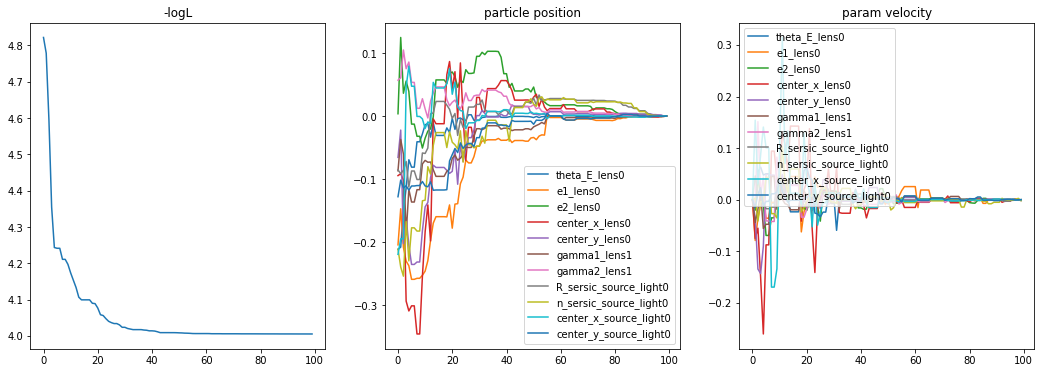

<Figure size 432x288 with 0 Axes>

In [34]:
# check PSO convergence plot
for i in range(len(chain_list)):
    if chain_list[i][0] == 'PSO':
        fig, axes = chain_plot.plot_chain_list(chain_list, i)
        #plt.show()

## Posterior inference

Using `emcee`.

In [35]:
start = time.time()
chain_list_sampling = fit_sequence.fit_sequence(
    [['MCMC', {'walkerRatio': 2, 'n_burn': 10, 'n_run': 10, 'sigma_scale': 1., 'threadCount': 1}]]
)
_, samples, param_list, logL = chain_list_sampling[-1]
runtime = time.time() - start
print(f"Runtime: {runtime}")
print(f"Samples shape: {samples.shape}")

100%|██████████| 20/20 [00:04<00:00,  4.49it/s]

Computing the MCMC...
Number of walkers =  22
Burn-in iterations:  10
Sampling iterations (in current run): 20
4.687128067016602 time taken for MCMC sampling
Runtime: 4.693682909011841
Samples shape: (220, 11)


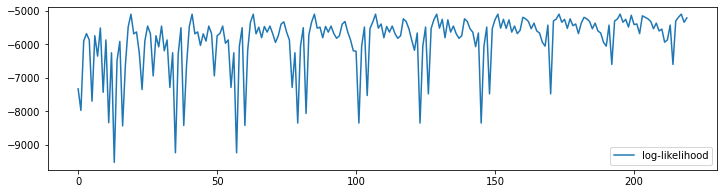

In [36]:
#print(extra_fields.keys())

fig, axes = plt.subplots(1, 1, figsize=(12, 3))
ax = axes
ax.plot(logL, label="log-likelihood")
ax.legend()
plt.show()

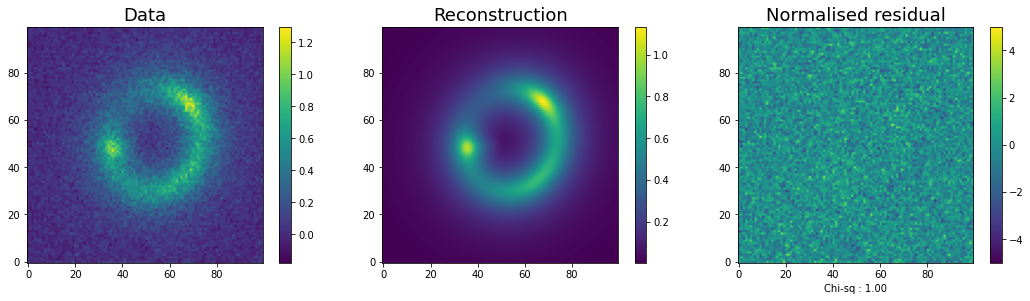

In [37]:
kwargs_posterior = deepcopy(fit_sequence.best_fit())

plot_image_model(kwargs_posterior)

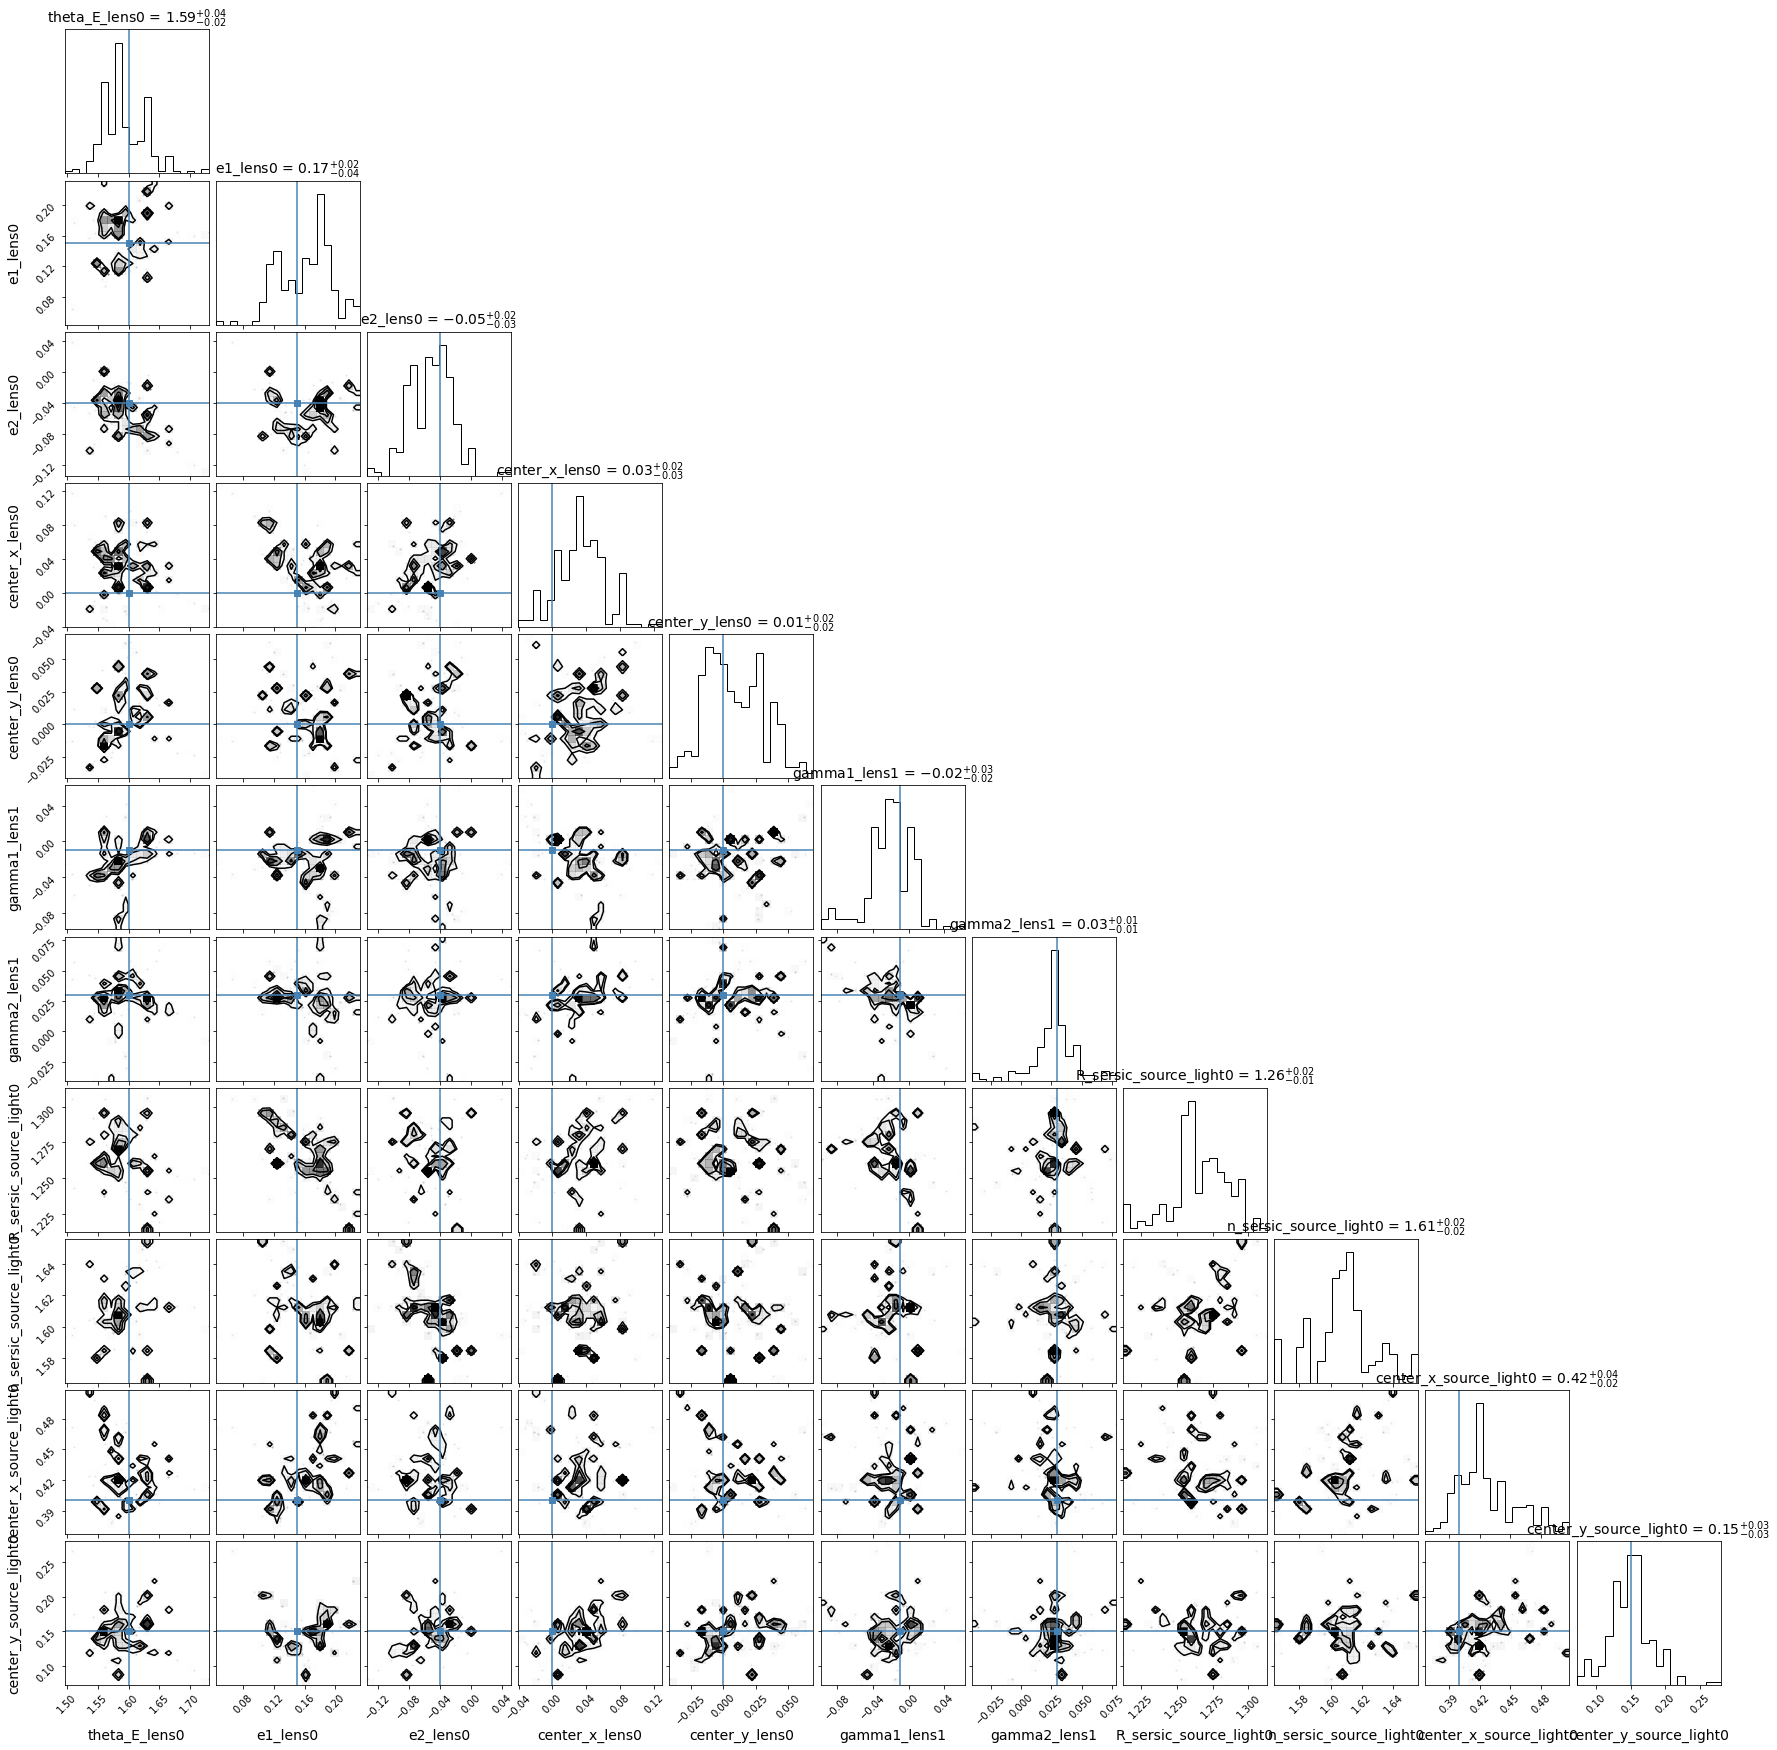

In [38]:
truths = fit_sequence.param_class.kwargs2args(**kwargs_true)
fig = corner.corner(samples, truths=truths, show_titles=True, 
                    labels=param_list, 
                    title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
plt.show()